## Downloading Dependencies

In [ ]:
# install torchaudio
!pip install torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 4.3MB/s 
     |████████████████████████████████| 577.3MB 24kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.7.0+cu92 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.0+cu92 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
# current torch version is 1.7.0+cu101
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
# check if cuda GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # should output "cuda"

cpu


## Speech Classification Dataset
We will be providing the base dataset that will be used for the first task of the Speech Classification competition.

In [ ]:
!gdown --id 1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
!unzip s1_train_release.zip

Downloading...
From: https://drive.google.com/uc?id=1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
To: /content/s1_train_release.zip
48.3MB [00:00, 67.2MB/s]
Archive:  s1_train_release.zip
   creating: s1_train_release/bird/
  inflating: s1_train_release/bird/train_bird_8400.wav  
  inflating: s1_train_release/bird/train_bird_8401.wav  
  inflating: s1_train_release/bird/train_bird_8402.wav  
  inflating: s1_train_release/bird/train_bird_8405.wav  
  inflating: s1_train_release/bird/train_bird_8406.wav  
  inflating: s1_train_release/bird/train_bird_8407.wav  
  inflating: s1_train_release/bird/train_bird_8408.wav  
  inflating: s1_train_release/bird/train_bird_8409.wav  
  inflating: s1_train_release/bird/train_bird_8411.wav  
  inflating: s1_train_release/bird/train_bird_8416.wav  
  inflating: s1_train_release/bird/train_bird_8417.wav  
  inflating: s1_train_release/bird/train_bird_8419.wav  
  inflating: s1_train_release/bird/train_bird_8420.wav  
  inflating: s1_train_release/bird/train_bird_8

In [ ]:
class CustomSpeechDataset(torch.utils.data.Dataset):
  def __init__(self, path, typ='train', transforms=None):

    assert typ == 'train' or typ == 'test', 'typ must be either "train" or "test"'

    self.typ = typ
    self.transforms = transforms
    self.targets = []

    if self.typ == 'train':
      self.class_names = sorted(os.listdir(path))
      num_classes = len(self.class_names)

      for class_idx, class_name in enumerate(self.class_names):
        class_dirx = os.path.join(path, class_name)
        wav_list = os.listdir(class_dirx)

        for wav_file in wav_list:
          self.targets.append({
              'filename': wav_file,
              'path': os.path.join(class_dirx, wav_file),
              'class': class_name
          })

    if self.typ == 'test':
      wav_list = os.listdir(path)
      for wav_file in wav_list:
        self.targets.append({
            'filename': wav_file,
            'path': os.path.join(path, wav_file)
        })
  
  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()

    signal, sr = torchaudio.load(self.targets[idx]['path'], normalization=True)
    filename = self.targets[idx]['filename']

    if self.transforms:
      for transform in self.transforms:
        signal = transform(signal)

    if self.typ == 'train':
      clx_name = self.targets[idx]['class']
      return filename, signal, sr, clx_name
    
    elif self.typ == 'test':
      return filename, signal, sr

In [ ]:
full_dataset = CustomSpeechDataset(path='s1_train_release', typ='train')
train_size = int(len(full_dataset)*0.8)
valid_size = len(full_dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

In [ ]:
labels = full_dataset.class_names

In [ ]:
labels_to_indices = {}
for idx, l in enumerate(labels):
  labels_to_indices[l] = idx

Example from the training set:

In [ ]:
filename, waveform, sample_rate, label_id = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


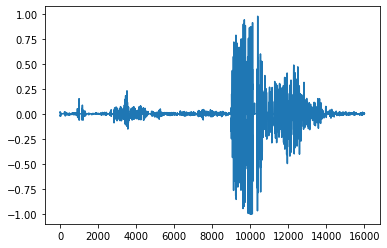

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Let's plot the waveform using matplotlib
# We observe that the main audio activity happens at the later end of the clip
plt.plot(waveform.t().numpy());

In [ ]:
# let's play the audio clip and hear it for ourselves!
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Constant Sample Lengths
Sample length varies across the audio clips -> Pad the audio clips to a maximum sample length of 16000. (16000 sample length is equal to 1 second at 16,000 Hz sampling rate)

Pad audio clips which are less than 1 second in length with parts of itself.

In [ ]:
audio_lens = []
for i in range(len(train_set)):
  audio_lens.append(train_set[i][1].size(1))

print('Max Sample Length:', max(audio_lens))
print('Min Sample Length:', min(audio_lens))

Max Sample Length: 16000
Min Sample Length: 16000


In [ ]:
class PadAudio(torch.nn.Module):
  def __init__(self, req_length = 16000):
    super().__init__()
    self.req_length = req_length

  def forward(self, waveform):
    while waveform.size(1) < self.req_length:
      waveform = torch.cat((waveform, waveform[:, :self.req_length - waveform.size(1)]), axis=1)
    return waveform

# Set up a list of transformations we are going to apply to the waveforms
transformations = []
transformations.append(PadAudio())

## Features
Instead of using the raw waveform of the audio clips, use melspectrograms instead: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

In [ ]:
from torchaudio.transforms import MelSpectrogram

# We define our own log transformation here
class LogMelTransform(torch.nn.Module):

    def __init__(self, log_offset = 1e-6):
        super().__init__()
        self.log_offset = log_offset

    def forward(self, melspectrogram):
        return torch.log(melspectrogram + self.log_offset)

# Let's append these new transformations
transformations.append(MelSpectrogram(sample_rate = 16000, n_mels = 128))
transformations.append(LogMelTransform())

## Data Augmentation

Data augmentation process in order to increase the variations in our dataset:

In the audio domain, the augmentation technique known as [SpecAugment](https://arxiv.org/abs/1904.08779) is often used. It makes use of 3 steps:
- Time Warp (warps the spectrogram to the left or right)
- Frequency Masking (randomly masks a range of frequencies)
- Time Masking (randomly masks a range of time)

As Time Warp is computationally intensive and does not contribute significant improvement in results, we shall simply use Frequency and Time Masking here.

In [ ]:
from torchaudio.transforms import TimeMasking, FrequencyMasking

eval_transformations = transformations.copy()

# Let's extend the list of transformations with the augmentations
transformations.append(TimeMasking(time_mask_param = 10)) # a maximum of 10 time steps will be masked
transformations.append(FrequencyMasking(freq_mask_param = 3)) # maximum of 3 freq channels will be masked

## Data Loaders

Set up data loaders so that we can streamline the batch loading of data for our model training later on. 

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True if device == 'cuda' else False

def train_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)

    return (tensors, targets, filenames)

def eval_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)
    filenames += [filename]

    return (tensors, targets, filenames)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=train_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=eval_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

## Setting up the Model

Use a LSTM-RNN for Speech Classification

### RNN - LSTM

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index

### Early Stopping

Credit: https://github.com/Bjarten/early-stopping-pytorch

(with some modifications)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, monitor='accuracy', patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.results = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.monitor = monitor

    def __call__(self, val_metric, model, results):

        if self.monitor == 'accuracy':
          score = val_metric
        else:
          score = -val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.results = results
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.results = results
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Model Training

In [ ]:
def train_model(input_size=128, hidden_size=128, num_layers=2, num_classes=len(labels), 
                m_device=device, classes=labels, lr=1e-4, num_epochs=50, early_stop=False, 
                monitor='accuracy', patience=10, verbose=True, seed=None, load_model=None, l2_reg=0):

  if seed:
    torch.manual_seed(seed)

  # initialize the model class
  model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
              num_classes=num_classes, device=m_device, classes=classes).to(m_device)

  if load_model:
    model.load_state_dict(torch.load(load_model))

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
  optimizer.zero_grad()
  #num_epochs = 100
  if early_stop:
    early_stopping = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose)

  for epoch in range(1,num_epochs+1):

    # training steps
    model.train()
    count_correct, count_total = 0, 0
    for idx, (features, targets, filenames) in enumerate(train_loader):

      features = features.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = model(features)
      loss = criterion(outputs, targets)

      # backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # training results
      _, argmax = torch.max(outputs, 1)
      count_correct += (targets == argmax.squeeze()).sum().item()
      count_total += targets.size(0)

    train_acc = count_correct / count_total
    
    # evaluation steps
    model.eval()
    count_correct, count_total = 0, 0
    with torch.no_grad():
      for idx, (features, targets, filenames) in enumerate(valid_loader):

        features = features.to(device)
        targets = targets.to(device)

        # forward pass
        val_outputs = model(features)
        val_loss = criterion(val_outputs, targets)

        # validation results
        _, argmax = torch.max(val_outputs, 1)
        count_correct += (targets == argmax.squeeze()).sum().item()
        count_total += targets.size(0)

    # print results
    valid_acc = count_correct / count_total

    print('Epoch [{}/{}], Train loss = {:.4f}, Train accuracy = {:.2f}, Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
        .format(epoch, num_epochs, loss.item(), 100*train_acc, val_loss.item(), 100*valid_acc))

    results = { 'epoch': epoch,
                'num_epochs': num_epochs,
                'train_loss': loss.item(),
                'train_acc': 100*train_acc,
                'val_loss': val_loss.item(),
                'val_acc': 100*valid_acc }

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    if monitor == 'accuracy':
      early_stopping(valid_acc, model, results)
    elif monitor == 'loss':
      early_stopping(results['val_loss'], model, results)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
          
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

  return model, early_stopping.results


NameError: ignored

### Test Functions

In [ ]:
train_model(num_epochs=100, early_stop=True, patience=15, seed=0)
torch.save(model.state_dict(), 'speech_classification_lstm.pt')

In [ ]:
model, _ = train_model(num_epochs=100, early_stop=True, patience=15, seed=0, load_model='speech_classification_lstm.pt')

In [ ]:
torch.save(model.state_dict(), 'speech_classification_lstm.pt')

In [ ]:
model.load_state_dict(torch.load('speech_classification_lstm.pt'))

In [ ]:
# evaluation steps
model.eval()
criterion = nn.CrossEntropyLoss()
count_correct, count_total = 0, 0
with torch.no_grad():
  for idx, (features, targets, filenames) in enumerate(valid_loader):

    features = features.to(device)
    targets = targets.to(device)

    # forward pass
    val_outputs = model(features)
    val_loss = criterion(val_outputs, targets)

    # validation results
    _, argmax = torch.max(val_outputs, 1)
    count_correct += (targets == argmax.squeeze()).sum().item()
    count_total += targets.size(0)

# print results
valid_acc = count_correct / count_total

print('Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
    .format(val_loss.item(), 100*valid_acc))

## Hyperparameter sweeps

### LR Sweep

In [ ]:
# LR sweep

lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
lr_sweep = []

for seed, lr in enumerate(lrs):
  model, results = train_model(num_epochs=100, early_stop=True, patience=15, seed=seed, lr=lr)

  lr_sweep_one = results
  lr_sweep_one['lr'] = lr 
  lr_sweep.append(lr_sweep_one)

In [ ]:
lr_sweep

### Hidden Size and Num Layers Sweep

In [ ]:
# Hidden Size and Num_layers sweep

lr = 8e-5
num_layers = [2,3,4,5]
hidden_sizes = [64,128,256,512]
sweep_results = []

for num_layer in num_layers:
  for hidden_size in hidden_sizes:
    model, results = train_model(num_epochs=100, early_stop=True, patience=15, seed=seed, lr=lr, num_layers=num_layer, hidden_size=hidden_size)

    results['hidden_size'] = hidden_size
    results['num_layers'] = num_layer
    sweep_results.append(results)

In [ ]:
sweep_results

In [ ]:
sr = pd.DataFrame(sweep_results)
sr.to_csv('sweep_results.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Regularization Sweep

In [ ]:
#l2s = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
l2s = [5e-1]
seed = 0
lr = 8e-5
num_layer = 3
hidden_size = 512
sweep_results = []

for l2 in l2s:
  model, results = train_model(num_epochs=100, early_stop=True, patience=10, seed=seed, lr=lr, num_layers=num_layer, hidden_size=hidden_size, l2_reg=l2)

  results['l2_reg'] = l2
  sweep_results.append(results)

Epoch [1/100], Train loss = 2.5594, Train accuracy = 7.69, Valid loss = 2.5712, Valid accuracy = 6.35
Validation loss decreased (inf --> 0.063462).  Saving model ...
Epoch [2/100], Train loss = 2.5665, Train accuracy = 7.36, Valid loss = 2.5680, Valid accuracy = 7.31
Validation loss decreased (0.063462 --> 0.073077).  Saving model ...
Epoch [3/100], Train loss = 2.5647, Train accuracy = 7.50, Valid loss = 2.5659, Valid accuracy = 8.08
Validation loss decreased (0.073077 --> 0.080769).  Saving model ...
Epoch [4/100], Train loss = 2.5655, Train accuracy = 7.60, Valid loss = 2.5656, Valid accuracy = 8.08
Validation loss decreased (0.080769 --> 0.080769).  Saving model ...
Epoch [5/100], Train loss = 2.5657, Train accuracy = 7.60, Valid loss = 2.5653, Valid accuracy = 8.08
Validation loss decreased (0.080769 --> 0.080769).  Saving model ...
Epoch [6/100], Train loss = 2.5652, Train accuracy = 7.60, Valid loss = 2.5650, Valid accuracy = 8.08
Validation loss decreased (0.080769 --> 0.080769

In [ ]:
sweep_results

[{'epoch': 14,
  'l2_reg': 5e-05,
  'num_epochs': 100,
  'train_acc': 73.89423076923077,
  'train_loss': 0.581122875213623,
  'val_acc': 75.1923076923077,
  'val_loss': 0.39064309000968933}]

In [ ]:
sr = pd.DataFrame(sweep_results)
sr.to_csv('sweep_results.csv')

## Model Choosing/Training

In [ ]:
rnn_model, results = train_model(hidden_size=512, num_layers=3, num_classes=len(labels), 
                m_device=device, classes=labels, lr=8e-5, num_epochs=100, early_stop=True, 
                monitor='loss', patience=10, verbose=True, seed=0, l2_reg=3e-5)

Epoch [1/100], Train loss = 2.4128, Train accuracy = 12.60, Valid loss = 2.7006, Valid accuracy = 12.31
Validation loss decreased (inf --> 0.123077).  Saving model ...
Epoch [2/100], Train loss = 2.1527, Train accuracy = 21.11, Valid loss = 2.8108, Valid accuracy = 25.58
Validation loss decreased (0.123077 --> 0.255769).  Saving model ...
Epoch [3/100], Train loss = 1.9488, Train accuracy = 31.83, Valid loss = 2.6170, Valid accuracy = 33.85
Validation loss decreased (0.255769 --> 0.338462).  Saving model ...
Epoch [4/100], Train loss = 1.6532, Train accuracy = 39.62, Valid loss = 2.3467, Valid accuracy = 41.15
Validation loss decreased (0.338462 --> 0.411538).  Saving model ...
Epoch [5/100], Train loss = 1.3966, Train accuracy = 49.04, Valid loss = 2.1681, Valid accuracy = 47.69
Validation loss decreased (0.411538 --> 0.476923).  Saving model ...
Epoch [6/100], Train loss = 1.2052, Train accuracy = 53.56, Valid loss = 1.9338, Valid accuracy = 50.58
Validation loss decreased (0.476923 

In [ ]:
torch.save(model.state_dict(), 'speech_classification_lstm.pt')

## Comparing the two

In [ ]:
# If saved model, can just start from here:
input_size=128
hidden_size=512
num_layers=3
old_model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
            num_classes=len(labels), device=device, classes=labels).to(device)
new_model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
            num_classes=len(labels), device=device, classes=labels).to(device)

# Load the model
old_model.load_state_dict(torch.load('speech_classification_lstm_1806.pt'))
new_model.load_state_dict(torch.load('speech_classification_lstm_2106.pt'))

<All keys matched successfully>

### DNN

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, dropout=0.25, classes=None):
        super(DNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        self.classes = classes

    def forward(self, x):
        out = self.dropout(F.relu(self.fc1(x)))

        for _ in range(self.num_layers):
          out = self.dropout(F.relu(self.fc2(out)))

        out = self.fc3(out)
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index

In [ ]:
def train_ensemble(model_list, hidden_size=128, num_layers=3, num_classes=len(labels), 
                    m_device=device, classes=labels, lr=1e-4, num_epochs=100, early_stop=True, 
                    monitor='accuracy', patience=10, verbose=True, seed=None, load_model=None, l2_reg=0, dropout=0.25):
  
    if seed:
      torch.manual_seed(seed)

    input_size = len(model_list) * num_classes
    # initialize the model class
    model = DNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                num_classes=num_classes, device=m_device, dropout=dropout, classes=classes).to(m_device)

    if load_model:
      model.load_state_dict(torch.load(load_model))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    optimizer.zero_grad()
    #num_epochs = 100
    if early_stop:
      early_stopping = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose)

    for submodel in model_list:
      for param in submodel.parameters():
        param.requires_grad = False

    for epoch in range(1,num_epochs+1):

      # training steps
      model.train()
      count_correct, count_total = 0, 0
      for idx, (features, targets, filenames) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)
        # forward pass
        xs = []
        for submodel in model_list:
          xs.append(submodel.train()(features))
        
        outputs = model(torch.cat(xs,axis=1))
        loss = criterion(outputs, targets)

        # backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # training results
        _, argmax = torch.max(outputs, 1)
        count_correct += (targets == argmax.squeeze()).sum().item()
        count_total += targets.size(0)

      train_acc = count_correct / count_total
      
      # evaluation steps
      model.eval()
      count_correct, count_total = 0, 0
      with torch.no_grad():
        for idx, (features, targets, filenames) in enumerate(valid_loader):

          features = features.to(device)
          targets = targets.to(device)
          
          # forward pass
          val_xs = []
          for submodel in model_list:
            val_xs.append(submodel.eval()(features))
          
          val_outputs = model(torch.cat(val_xs,axis=1))
          val_loss = criterion(val_outputs, targets)

          # validation results
          _, argmax = torch.max(val_outputs, 1)
          count_correct += (targets == argmax.squeeze()).sum().item()
          count_total += targets.size(0)

      # print results
      valid_acc = count_correct / count_total

      print('Epoch [{}/{}], Train loss = {:.4f}, Train accuracy = {:.2f}, Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
          .format(epoch, num_epochs, loss.item(), 100*train_acc, val_loss.item(), 100*valid_acc))

      results = { 'epoch': epoch,
                  'num_epochs': num_epochs,
                  'train_loss': loss.item(),
                  'train_acc': 100*train_acc,
                  'val_loss': val_loss.item(),
                  'val_acc': 100*valid_acc }

      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
      early_stopping(valid_acc, model, results)
      
      if early_stopping.early_stop:
          print("Early stopping")
          break
            
      # load the last checkpoint with the best model
      model.load_state_dict(torch.load('checkpoint.pt'))

    return model, early_stopping.results



In [ ]:
model, results = train_ensemble([old_model, new_model], hidden_size=64, num_layers=2, num_classes=len(labels), 
                m_device=device, classes=labels, lr=1e-4, num_epochs=100, early_stop=True, 
                monitor='accuracy', patience=10, verbose=True, seed=0, dropout=0.25, l2_reg=1e-5)

Epoch [1/100], Train loss = 2.5209, Train accuracy = 9.09, Valid loss = 2.5326, Valid accuracy = 13.27
Validation loss decreased (inf --> 0.132692).  Saving model ...
Epoch [2/100], Train loss = 2.4601, Train accuracy = 15.77, Valid loss = 2.4873, Valid accuracy = 33.08
Validation loss decreased (0.132692 --> 0.330769).  Saving model ...
Epoch [3/100], Train loss = 2.3824, Train accuracy = 26.01, Valid loss = 2.4083, Valid accuracy = 45.77
Validation loss decreased (0.330769 --> 0.457692).  Saving model ...
Epoch [4/100], Train loss = 2.2968, Train accuracy = 35.53, Valid loss = 2.2965, Valid accuracy = 55.00
Validation loss decreased (0.457692 --> 0.550000).  Saving model ...
Epoch [5/100], Train loss = 2.0103, Train accuracy = 41.83, Valid loss = 2.1453, Valid accuracy = 65.58
Validation loss decreased (0.550000 --> 0.655769).  Saving model ...
Epoch [6/100], Train loss = 1.8469, Train accuracy = 48.75, Valid loss = 1.9670, Valid accuracy = 73.46
Validation loss decreased (0.655769 -

In [ ]:
torch.save(model.state_dict(), 'speech_classification_dnn_2206.pt')

## Test Set

In [ ]:
# If saved model, can just start from here:
#model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
#            num_classes=num_classes, device=m_device, classes=classes).to(m_device)

# Load the model
model.load_state_dict(torch.load('speech_classification_lstm.pt'))

<All keys matched successfully>

In [ ]:
!gdown --id 1AvP49xengGjnFTG209AgvAGj-by8WGSi
!unzip -q -o s1_test.zip

Downloading...
From: https://drive.google.com/uc?id=1AvP49xengGjnFTG209AgvAGj-by8WGSi
To: /content/s1_test.zip
12.3MB [00:00, 74.5MB/s]


In [ ]:
# Initialise dataset object for test set
test_set = CustomSpeechDataset(path='s1_test', typ='test')

In [ ]:
# define test collate function and set up test loader

def test_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate

    tensors, filenames = [], []

    # Gather in lists
    for filename, waveform, sample_rate in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)

    return (tensors, filenames)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=test_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

Either

In [ ]:
# pass test set through the RNN model
model.eval()
pred_list, filename_list = [], []
with torch.no_grad():
  for idx, (features, filenames) in enumerate(test_loader):

    features = features.to(device)

    # forward pass
    outputs = model(features)

    # validation results
    _, argmax = torch.max(outputs, 1)
    pred_list += argmax.cpu().tolist()
    filename_list += filenames

Or

In [ ]:
# pass test set through the Ensemble
model.eval()
pred_list, filename_list = [], []
model_list=[old_model, new_model]
with torch.no_grad():
  for idx, (features, filenames) in enumerate(test_loader):

    features = features.to(device)

    # forward pass
    xs = []
    for submodel in model_list:
      xs.append(submodel.train()(features))
    
    outputs = model(torch.cat(xs,axis=1))

    # validation results
    _, argmax = torch.max(outputs, 1)
    pred_list += argmax.cpu().tolist()
    filename_list += filenames

### Listen to specific examples

AttributeError: ignored

In [ ]:
interested = ['0003', '0048', '0077', '0166', '0240']
base1 = 's1_test_'
base2 = '.wav'
for i in range(649):
  filename, _, _ = test_set[i]
  
  for name in interested:
    if base1+name+base2 == filename:
      print(i)  

69
180
489
541
572


In [ ]:
filename, waveform, sample_rate = test_set[572]
print(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

s1_test_0048.wav


## Submission of Results
Submission csv file should contain only 2 columns for filename and label, in that order. The file should be sorted by filename, and exclude headers. 

Refer to **sample_submission.csv** for an example.

In [ ]:
result_tuple = list(zip(filename_list, pred_list))
submission = pd.DataFrame(result_tuple, columns=['filename', 'pred'])
submission = submission.sort_values('filename').reset_index(drop=True)
submission['label'] = submission['pred'].apply(lambda x: labels[x])

In [ ]:
submission[['filename', 'label']].head()
submission[['filename', 'label']].to_csv('submission.csv', header=None, index=None)